# Unsupervised Machine Learning for the Classification of Astrophysical X-ray Sources
###### *Víctor Samuel Pérez Díaz<sup>1,2</sup>, Rafael Martinez-Galarza<sup>1</sup>, Alexander Caicedo-Dorado<sup>3</sup>, Raffaele D'Abrusco<sup>1</sup>*

*1. Center for Astrophysics | Harvard & Smithsonian, 2. Universidad del Rosario, 3. Pontificia Universidad Javeriana*

Contact ```vperezdiaz@cfa.harvard.edu``` for questions or comments.


#### Classification exploration

---

In [1]:
%load_ext autoreload
%autoreload 2

from umlcaxs_lib import votable_to_pandas, lognorm, mahalanobis, mahal_classifier_cl, create_summary_tables, process_data_for_validation, mahal_classifier_validation
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.stats import inter_rater as irr

from collections import Counter

from urllib.parse import urlencode
from astropy.io import fits
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astroquery.hips2fits import hips2fits
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import astropy.units as u
from astropy.coordinates import Longitude, Latitude, Angle
import aplpy

from scipy.stats import gaussian_kde

%matplotlib inline

In [2]:
# Edit the font, font size, and axes width

mpl.rcParams['font.family'] = 'Avenir LT Std'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

In [3]:
df_classified_cscs = pd.read_csv('./out_data/classified_cscs.csv', index_col=0)
df_class_agreeing = pd.read_csv('./out_data/agreeing_classification.csv', index_col=0)
df_classified_cscs.set_index('name', inplace=True)
df_class_confused = pd.read_csv('./out_data/confused_classification.csv', index_col=0)
df_cluster_csc_simbad = pd.read_csv('./out_data/cluster_csc_simbad.csv', index_col=0)
ltypes = ['QSO', 'AGN', 'Seyfert_1', 'Seyfert_2', 'HMXB', 'LMXB', 'XB', 'YSO', 'TTau*', 'Orion_V*']
grouped_types = ['AGN', 'Seyfert', 'XB', 'YSO']
grouped_replace = {'QSO': 'AGN', 'Seyfert_1': 'Seyfert', 'Seyfert_2': 'Seyfert', 'HMXB': 'XB', 'LMXB':'XB', 'TTau*':'YSO', 'Orion_V*': 'YSO' }
df_class_cscs_grouped = df_classified_cscs.main_type.replace(grouped_replace)

/tmp/ipykernel_19207/3008940862.py:5: DtypeWarning: Columns (56,63,64,65,66,67,68,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cluster_csc_simbad = pd.read_csv('./out_data/cluster_csc_simbad.csv', index_col=0)


In [4]:
nans_df_csc_simbad = df_cluster_csc_simbad.copy(deep=True).fillna({'main_type': 'NaN'})

In [5]:
# Features that we use in our analysis
features = ['hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_ratio_b', 'var_prob_h', 'var_ratio_h', 'var_prob_s', 'var_ratio_s', 'var_newq_b']

# Features to log transform and normalize
features_lognorm = ['bb_kt', 'var_ratio_h', 'var_ratio_b', 'var_ratio_s', 'var_newq_b']

# Features to normalize
features_norm = ['powlaw_gamma']

# Drop data with missing values in features
df_cscs_out = nans_df_csc_simbad.dropna(subset=features)

In [6]:
uks = ['Star', 'X', 'Radio', 'IR', 'Blue', 'UV', 'gamma', 'PartofG', '**']

df_cscs_out_clean = process_data_for_validation(df_cscs_out, ltypes, uks=uks)

In [ ]:
uks = ['Star', 'X', 'Radio', 'IR', 'Blue', 'UV', 'gamma', 'PartofG', '**']
nans_df_csc_simbad = df_cluster_csc_simbad.copy(deep=True).fillna({'main_type': 'NaN'})
create_summary_tables(nans_df_csc_simbad[nans_df_csc_simbad.cluster==5]).head(10).to_latex('latex_file.txt')

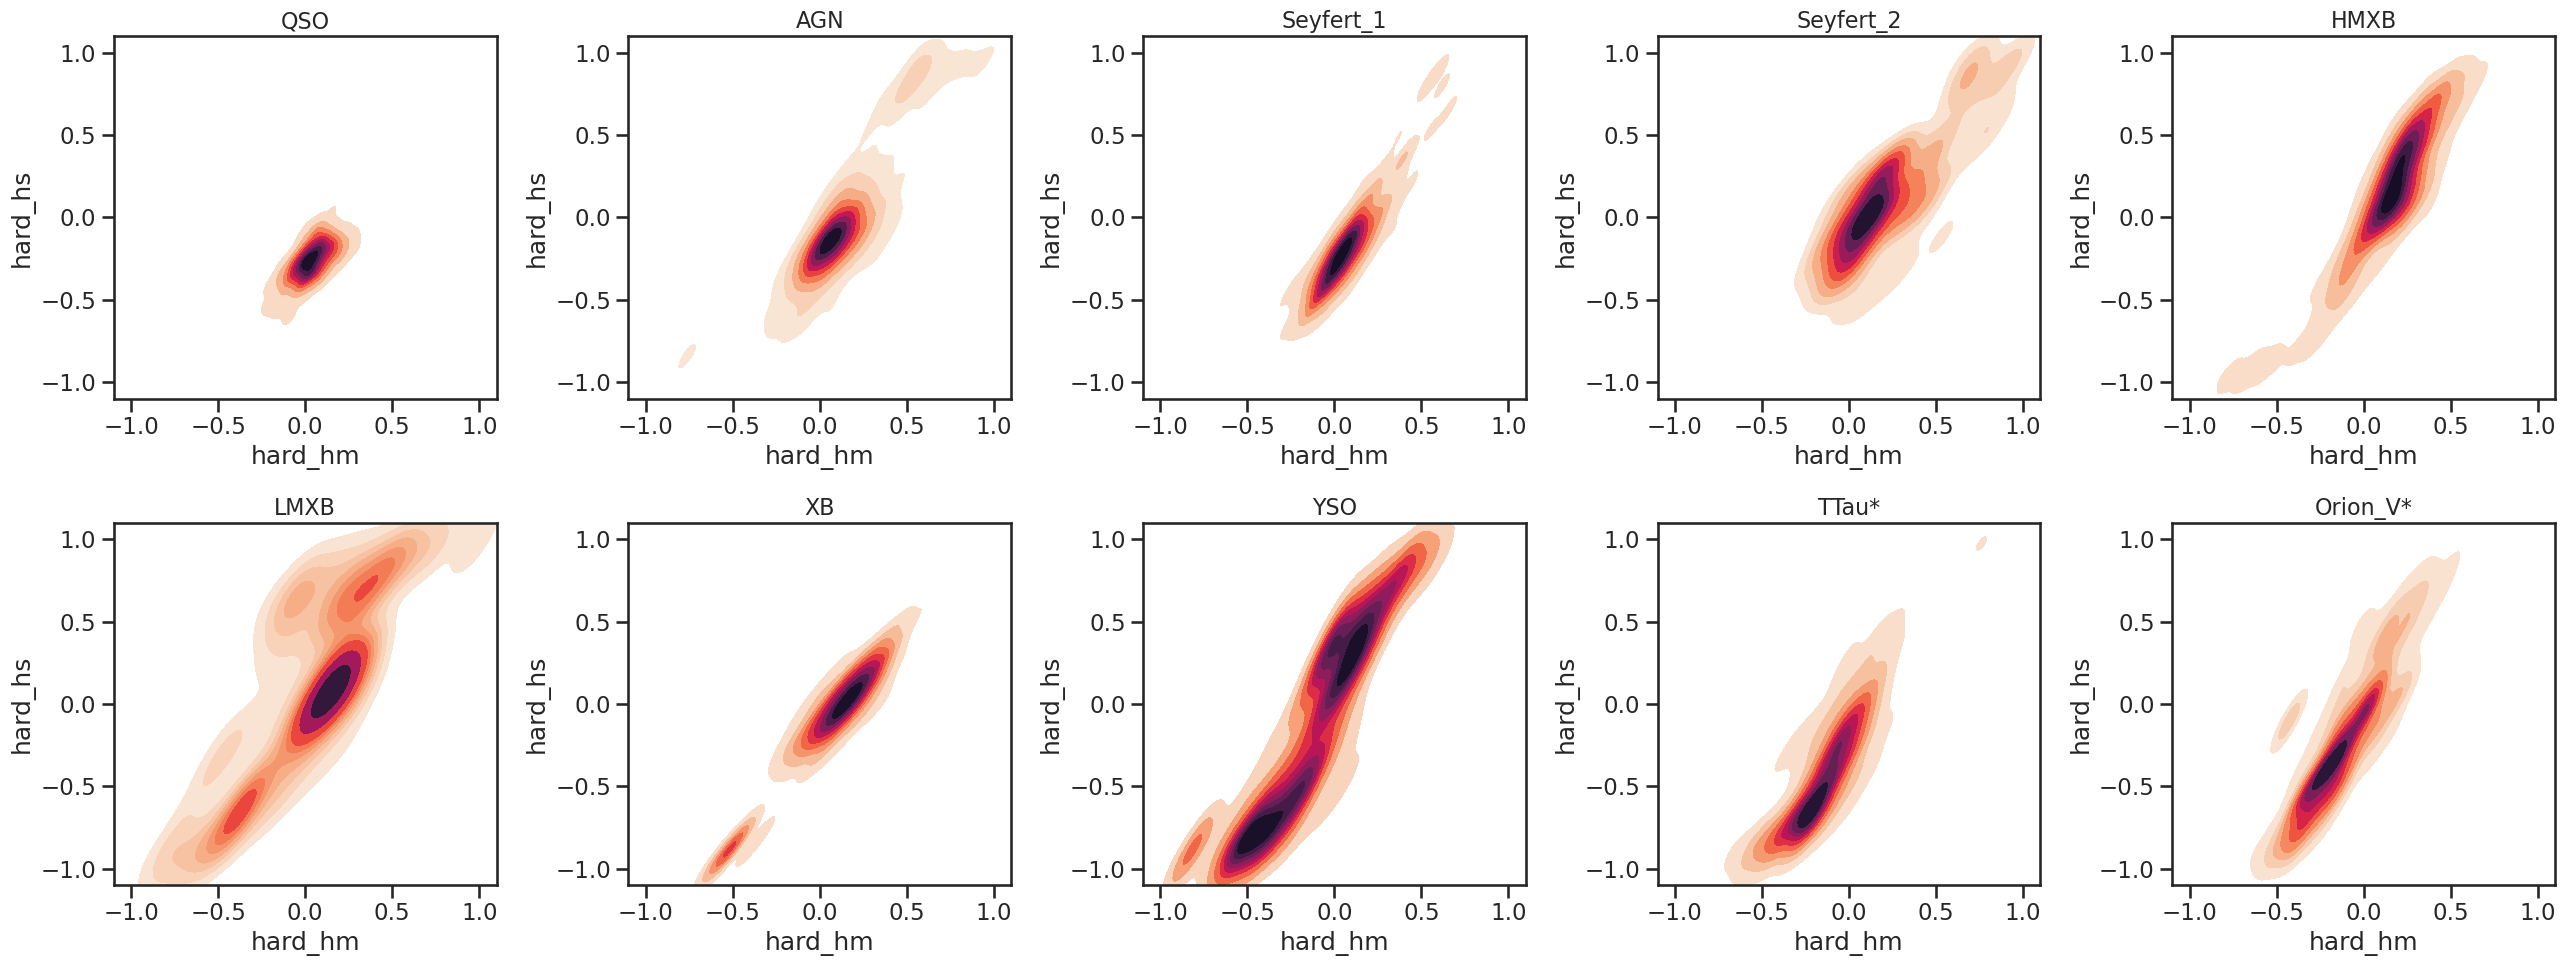

In [11]:
#plt.style.use("dark_background")
fig, axs = plt.subplots(2, 5, figsize=(26,10), tight_layout=True)

colx = df_classified_cscs.columns.get_loc("hard_hm")
coly = df_classified_cscs.columns.get_loc("hard_hs")

for i, ax in enumerate(fig.axes):
    sns.set(style="ticks", context="talk")
    ax.set_title(f'{ltypes[i]}', size=16)
    
    #ax.grid(True)
    ax.set_xlabel(df_classified_cscs.columns[colx])
    ax.set_ylabel(df_classified_cscs.columns[coly])
    g=sns.kdeplot(data=df_classified_cscs[df_classified_cscs.main_type==ltypes[i]], x='hard_hm', y='hard_hs', cmap='rocket_r', fill=True, alpha=1, ax=ax)
    
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

plt.savefig('./figures/white_results_class_exp_hard.pdf', bbox_inches='tight')  

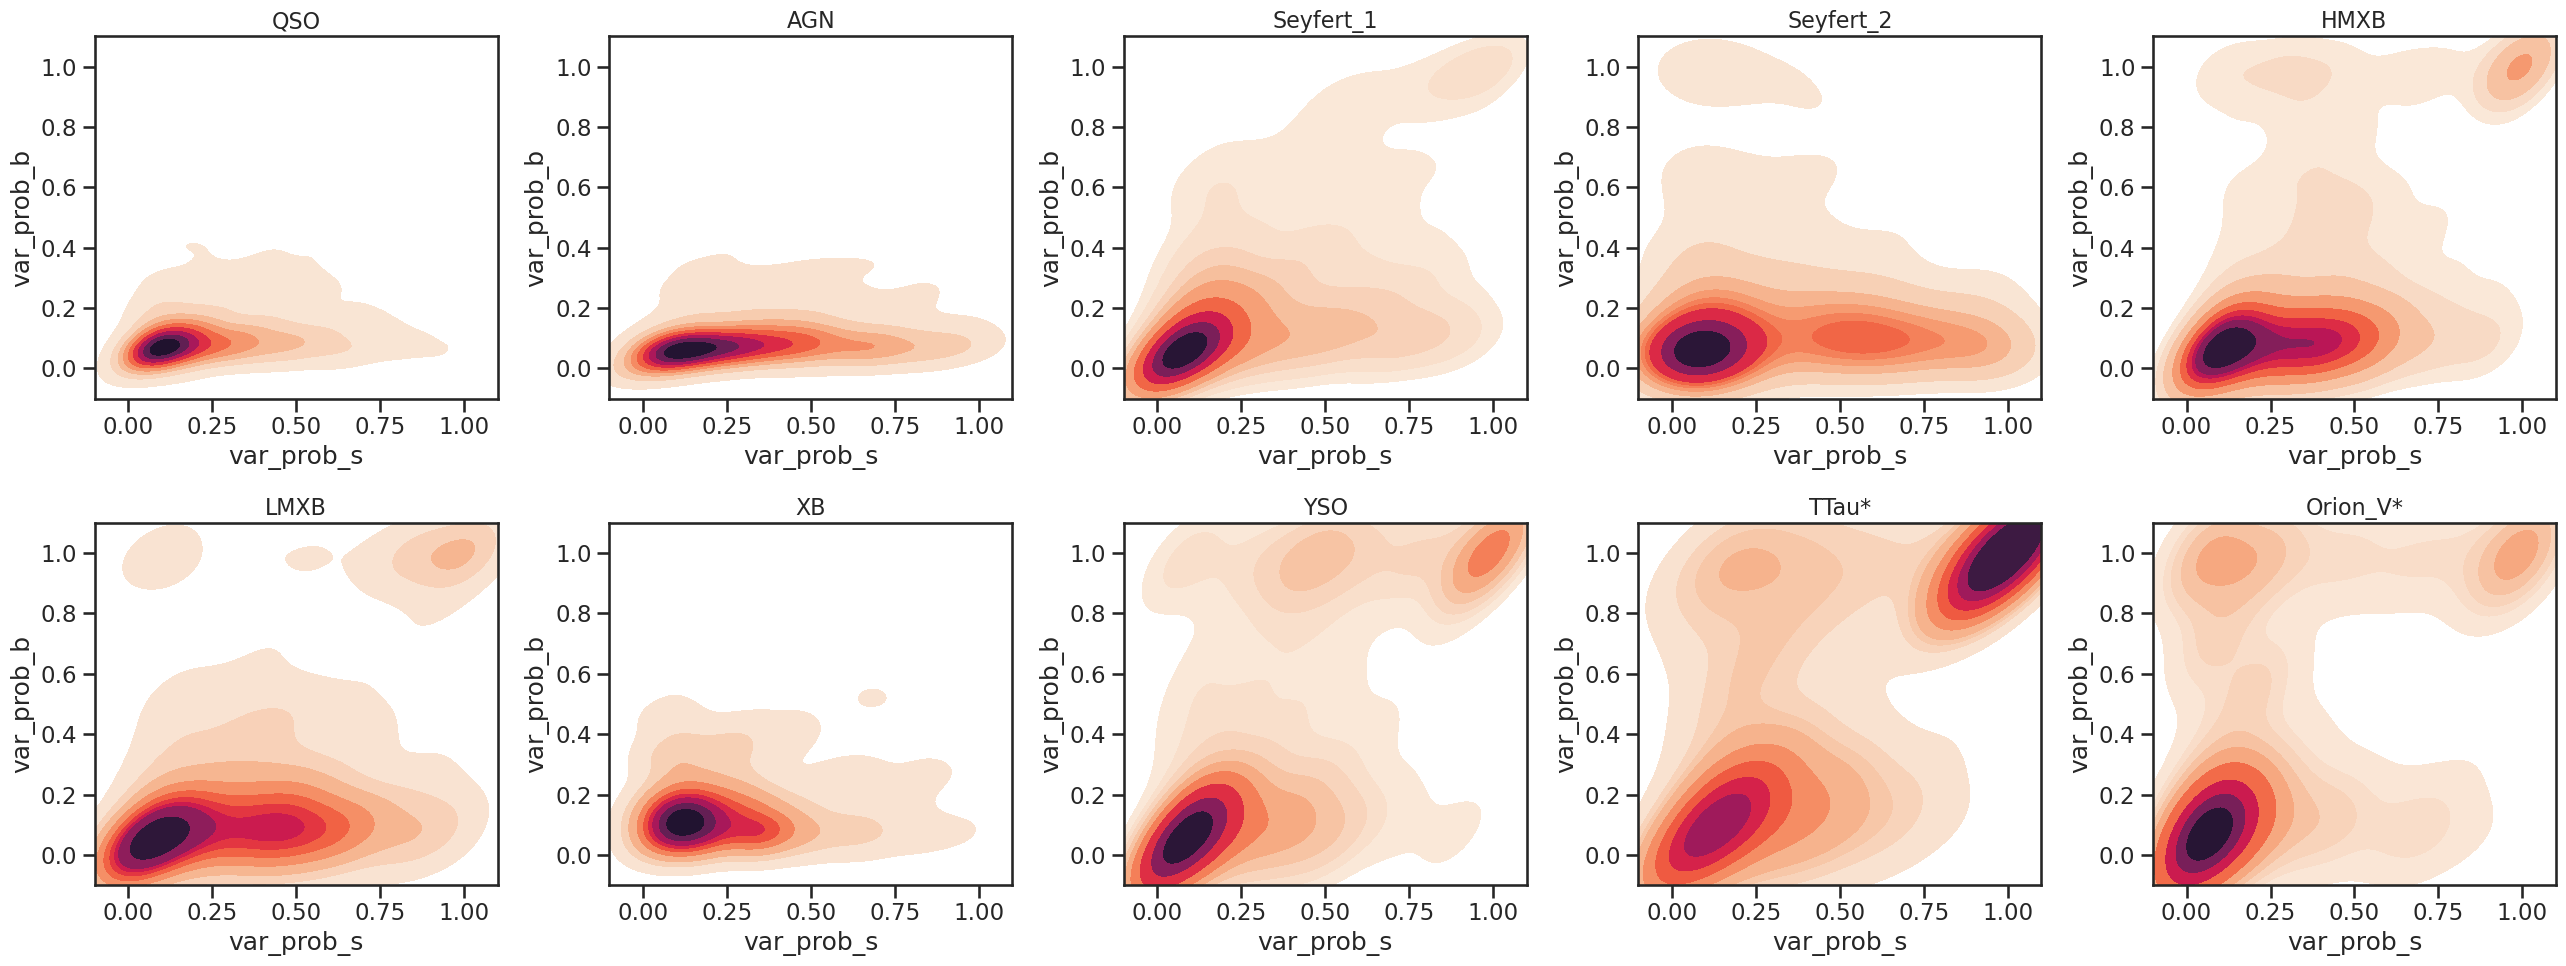

In [12]:
#plt.style.use("dark_background")
fig, axs = plt.subplots(2, 5, figsize=(26,10), tight_layout=True)

colx = df_classified_cscs.columns.get_loc("var_prob_s")
coly = df_classified_cscs.columns.get_loc("var_prob_b")

for i, ax in enumerate(fig.axes):
    sns.set(style="ticks", context="talk")
    ax.set_title(f'{ltypes[i]}', size=16)
    
    #ax.grid(True)
    ax.set_xlabel(df_classified_cscs.columns[colx])
    ax.set_ylabel(df_classified_cscs.columns[coly])
    g=sns.kdeplot(data=df_classified_cscs[df_classified_cscs.main_type==ltypes[i]], x='var_prob_s', y='var_prob_b', cmap='rocket_r', fill=True, alpha=1, ax=ax)
    
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])

plt.savefig('./figures/white_results_class_exp_var.pdf', bbox_inches='tight')  

In [ ]:
plt.style.use("dark_background")
fig, axs = plt.subplots(2, 2, figsize=(16,10), tight_layout=True)

colx = df_classified_cscs.columns.get_loc("hard_hm")
coly = df_classified_cscs.columns.get_loc("hard_hs")

for i, ax in enumerate(fig.axes):
    sns.set(style="ticks", context="talk")
    ax.set_title(f'{grouped_types[i]}', size=16)
    
    #ax.grid(True)
    ax.set_xlabel(df_classified_cscs.columns[colx])
    ax.set_ylabel(df_classified_cscs.columns[coly])
    g=sns.kdeplot(data=df_classified_cscs[df_class_cscs_grouped==grouped_types[i]], x='hard_hm', y='hard_hs', cmap='inferno', fill=True, alpha=1, ax=ax)
    
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

plt.savefig('./figures/results_class_exp_hard_grouped.pdf', bbox_inches='tight')  

In [ ]:
plt.style.use("dark_background")
fig, axs = plt.subplots(2, 2, figsize=(16,10), tight_layout=True)

colx = df_classified_cscs.columns.get_loc("var_prob_s")
coly = df_classified_cscs.columns.get_loc("var_prob_b")

for i, ax in enumerate(fig.axes):
    sns.set(style="ticks", context="talk")
    ax.set_title(f'{grouped_types[i]}', size=16)
    
    #ax.grid(True)
    ax.set_xlabel(df_classified_cscs.columns[colx])
    ax.set_ylabel(df_classified_cscs.columns[coly])
    g=sns.kdeplot(data=df_classified_cscs[df_class_cscs_grouped==grouped_types[i]], x='var_prob_s', y='var_prob_b', cmap='inferno', fill=True, alpha=1, bw_adjust=.1, ax=ax)
    #g=sns.scatterplot(data=df_classified_cscs[df_class_cscs_grouped==grouped_types[i]], x='var_prob_s', y='var_prob_b', s=10, ax=ax)
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])

plt.savefig('./figures/results_class_exp_var_grouped.pdf', bbox_inches='tight')  

#### Position in sky
---

In [16]:
query_results = Simbad.query_region('M42')                                                      
object_main_id = query_results[0]['MAIN_ID']
object_coords = SkyCoord(ra=query_results['RA'], dec=query_results['DEC'], 
                         unit=(u.hourangle, u.deg), frame='icrs')

In [18]:
hips_allwise = 'CDS/P/allWISE/W1'
result1 = hips2fits.query(
   hips=hips_allwise,
   width=1000,
   height=500,
   ra=object_coords[0].ra,
   dec=object_coords[0].dec,
   fov=Angle(4 * u.deg),
   projection="AIT",
   get_query_payload=False,
   format='fits',
   min_cut=0.5,
   max_cut=99.5,
   cmap=Colormap('viridis'),
)

In [ ]:
# Define a dictionary for class settings
class_settings = {
    'AGN': {'color': 0, 'marker': '^', 'label': 'AGN'},
    'Seyfert': {'color': 1, 'marker': 'X', 'label': 'Seyfert'},
    'XB': {'color': 2, 'marker': 's', 'label': 'XB'},
    'YSO': {'color': 3, 'marker': 'o', 'label': 'YSO'}
}

# Define color palette
colors = sns.color_palette("bright", len(class_settings))

gc = aplpy.FITSFigure(result1) 
gc.show_grayscale() 

for class_name, settings in class_settings.items():
    df_class = df_classified_cscs.loc[df_class_agreeing[df_class_agreeing.agg_master_class==class_name].index].drop_duplicates()
    gc.show_markers(df_class.ra, df_class.dec, layer=f'marker_set_{settings["color"]}',
                    facecolor=np.array(colors[settings["color"]]), edgecolor='white', marker=settings["marker"], s=40, alpha=0.5, label=settings["label"])

gc.axis_labels.set_xtext('RA')
gc.axis_labels.set_ytext('Dec')
plt.legend(facecolor='k', labelcolor='w')

#plt.savefig('./figures/m42.pdf', bbox_inches='tight')  

In [ ]:
# COSMOS
query_results = Simbad.query_region('Cosmos Field')                                                      
object_main_id = query_results[0]['MAIN_ID']
object_coords_cosmos = SkyCoord(ra=query_results['RA'], dec=query_results['DEC'], 
                         unit=(u.hourangle, u.deg), frame='icrs')

result2 = hips2fits.query(
   hips=hips_allwise,
   width=1000,
   height=500,
   ra=object_coords_cosmos[0].ra,
   dec=object_coords_cosmos[0].dec,
   fov=Angle(30 * u.deg),
   projection="AIT",
   get_query_payload=False,
   format='fits',
   min_cut=0.5,
   max_cut=99.5,
   cmap=Colormap('viridis'),
)

In [ ]:
gc = aplpy.FITSFigure(result2) 
gc.show_grayscale() 

gc.show_markers(df_agn.ra, df_agn.dec, layer='marker_set_1',
                facecolor=np.array(colors[0]), edgecolor='white', marker='^', s=40, alpha=0.5, label='AGN')

gc.show_markers(df_sey.ra, df_sey.dec, layer='marker_set_2',
                facecolor=np.array(colors[1]),edgecolor='white', marker='X', s=40, alpha=0.5, label='Seyfert')

gc.show_markers(df_xb.ra, df_xb.dec, layer='marker_set_3',
                facecolor=np.array(colors[2]), edgecolor='white', marker='s', s=40, alpha=0.5, label='XB')

gc.show_markers(df_yso.ra, df_yso.dec, layer='marker_set_4',
               facecolor=np.array(colors[3]), edgecolor='white', marker='o', s=40, alpha=0.5, label='YSO')
gc.axis_labels.set_xtext('RA')
gc.axis_labels.set_ytext('Dec')
plt.legend(facecolor='k', labelcolor='w')

plt.savefig('./figures/cosmos.pdf', bbox_inches='tight')  

In [ ]:
# M33
query_results = Simbad.query_region('M33')                                                      
object_main_id = query_results[0]['MAIN_ID']
object_coords_m33 = SkyCoord(ra=query_results['RA'], dec=query_results['DEC'], 
                         unit=(u.hourangle, u.deg), frame='icrs')

result3 = hips2fits.query(
   hips=hips_allwise,
   width=1000,
   height=500,
   ra=object_coords_m33[0].ra,
   dec=object_coords_m33[0].dec,
   fov=Angle(2 * u.deg),
   projection="AIT",
   get_query_payload=False,
   format='fits',
   min_cut=0.5,
   max_cut=99.5,
   cmap=Colormap('viridis'),
)

In [ ]:
gc = aplpy.FITSFigure(result3) 
gc.show_grayscale() 

gc.show_markers(df_agn.ra, df_agn.dec, layer='marker_set_1',
                facecolor=np.array(colors[0]), edgecolor='white', marker='^', s=40, alpha=0.5, label='AGN')

gc.show_markers(df_sey.ra, df_sey.dec, layer='marker_set_2',
                facecolor=np.array(colors[1]),edgecolor='white', marker='X', s=40, alpha=0.5, label='Seyfert')

gc.show_markers(df_xb.ra, df_xb.dec, layer='marker_set_3',
                facecolor=np.array(colors[2]), edgecolor='white', marker='s', s=40, alpha=0.5, label='XB')

gc.show_markers(df_yso.ra, df_yso.dec, layer='marker_set_4',
               facecolor=np.array(colors[3]), edgecolor='white', marker='o', s=40, alpha=0.5, label='YSO')
gc.axis_labels.set_xtext('RA')
gc.axis_labels.set_ytext('Dec')
plt.legend(facecolor='k', labelcolor='w')

plt.savefig('./figures/m33.pdf', bbox_inches='tight')  

In [136]:
# NGC 4649
hips_allwise = 'CDS/P/DSS2/NIR'
query_results = Simbad.query_region('NGC 4649')                                                      
object_main_id = query_results[0]['MAIN_ID']
object_coords_m33 = SkyCoord(ra=query_results['RA'], dec=query_results['DEC'], 
                         unit=(u.hourangle, u.deg), frame='icrs')

result_ngc4649 = hips2fits.query(
   hips=hips_allwise,
   width=1000,
   height=500,
   ra=object_coords_m33[0].ra,
   dec=object_coords_m33[0].dec,
   fov=Angle(0.15 * u.deg),
   projection="AIT",
   get_query_payload=False,
   format='fits',
   min_cut=0.5,
   max_cut=99.5,
   cmap=Colormap('viridis'),
)

In [139]:
gc = aplpy.FITSFigure(result_ngc4649)
gc.show_grayscale()

for class_name, settings in class_settings.items():
    df_class = df_classified_cscs.loc[df_class_agreeing[df_class_agreeing.agg_master_class==class_name].index].drop_duplicates()
    gc.show_markers(df_class.ra, df_class.dec, layer=f'marker_set_{settings["color"]}',
                    facecolor=np.array(colors[settings["color"]]), edgecolor='black', marker=settings["marker"], s=40, alpha=0.5, label=settings["label"])

gc.axis_labels.set_xtext('RA')
gc.axis_labels.set_ytext('Dec')
plt.legend(facecolor='k', labelcolor='w')

plt.savefig('./figures/ngc4649.pdf', bbox_inches='tight')  

INFO: Auto-setting vmin to  1.530e+03 [aplpy.core]
INFO: Auto-setting vmax to  2.602e+04 [aplpy.core]


#### Probabilities

---

In [ ]:
def plot_source_probability(df, df_c, source_name, ltypes):
    target_df_melted = pd.melt(df[ltypes], value_vars=ltypes, ignore_index=False)
    target_df = target_df_melted[target_df_melted.index == source_name]
    confident_class = df_c[df_c.index == source_name].master_class[0]
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
    
    ax1.yaxis.set_tick_params(which='major', size=6, width=0.5, direction='in')
    ax1.yaxis.set_tick_params(which='minor', size=3, width=0.5, direction='in')
    ax1.xaxis.set_tick_params(which='major', size=6, width=0.5, direction='out')
    ax1.xaxis.set_tick_params(which='minor', size=3, width=0.5, direction='out')
    ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
    ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.125))
    sns.lineplot(data=target_df, x='variable', y='value', color='black', markers=True, marker='o', ax=ax1)
    ax1.scatter(x=confident_class, y=target_df[target_df.variable == confident_class].mean(), marker='s', c='r', edgecolors='black', s=100, zorder=3)
    ax1.set_xticks(ltypes)
    ax1.set_xticklabels(ltypes, rotation=90)
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Probability')
    ax1.set_ylim([-0.05,1.05])
    ax1.set_title(source_name+', '+str(confident_class), fontsize=12)


In [ ]:
sname = '2CXO J033829.0-352701'
plot_source_probability(df_classified_cscs, df_class_agreeing, sname, ltypes)
#plt.savefig('figures/{}.pdf'.format(sname), dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
sname = '2CXO J053747.4-691019'
plot_source_probability(df_classified_cscs, df_class_agreeing, sname, ltypes)
#plt.savefig('figures/{}.pdf'.format(sname), dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
df_class_agreeing[df_class_agreeing.index == '2CXO J033829.0-352701']

In [ ]:
df_class_confused

In [ ]:
grouped_replace_c = {'AGN':'AGN+Seyfert','QSO': 'AGN+Seyfert', 'Seyfert_1': 'AGN+Seyfert', 'Seyfert_2': 'AGN+Seyfert', 'HMXB': 'XB', 'LMXB':'XB', 'TTau*':'YSO', 'Orion_V*': 'YSO'}

sum(df_class_confused.hard_master_class.replace(grouped_replace_c) == df_class_confused.soft_master_class.replace(grouped_replace_c))

In [ ]:
plt.style.use("dark_background")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), tight_layout=True)

source_props = df_classified_cscs[df_classified_cscs.index == sname]
xname = 'hard_hm'
yname = 'hard_hs'
classname = 'YSO'#df_class_confident[df_class_confident.index==sname].master_class[0]
sns.set(style="ticks", context="talk")
sns.kdeplot(data=df_cscs_out_clean[df_cscs_out_clean.main_type==classname], x=xname, y=yname, cmap='inferno', fill=True, alpha=1, ax=ax1)
sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax1)

sns.kdeplot(data=df_classified_cscs[df_classified_cscs.main_type==classname], x=xname, y=yname, cmap='inferno', fill=True, alpha=1, ax=ax2)
sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax2, label=f'{sname}')

ax1.set_xlim([-1.1,1.1])
ax1.set_ylim([-1.1,1.1])
ax2.set_xlim([-1.1,1.1])
ax2.set_ylim([-1.1,1.1])

ax1.set_title('"Training" sources')
ax2.set_title('Confident classified sources')
plt.legend()

fig.suptitle(f'{classname}', color='white')

#plt.savefig(f'figures/{sname}_dist_powbb_{classname}.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
from itertools import combinations

classname = 'YSO'#df_class_confident[df_class_confident.index==sname].master_class[0]
df_cscs_out_clean_lognorm = lognorm(df_cscs_out_clean, features, features_norm, features_lognorm)
df_classified_cscs_lognorm = lognorm(df_classified_cscs, features, features_norm, features_lognorm)
source_props = df_classified_cscs_lognorm[df_classified_cscs_lognorm.name == sname]

for feats in combinations(features, 2):
    plt.style.use("dark_background")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), tight_layout=True)
    xname = feats[0]
    yname = feats[1]
    sns.set(style="ticks", context="talk")
    sns.kdeplot(data=df_cscs_out_clean_lognorm[df_cscs_out_clean_lognorm.main_type==classname], x=xname, y=yname, cmap='inferno', fill=True, alpha=1,  bw_adjust=.4, ax=ax1)
    sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax1)

    sns.kdeplot(data=df_classified_cscs_lognorm[df_classified_cscs_lognorm.main_type==classname], x=xname, y=yname, cmap='inferno', fill=True, alpha=1,  bw_adjust=.4, ax=ax2)
    sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax2, label=f'{sname}')

    #ax1.set_xlim([-1.1,1.1])
    #ax1.set_ylim([-1.1,1.1])
    #ax2.set_xlim([-1.1,1.1])
    #ax2.set_ylim([-1.1,1.1])

    ax1.set_title('"Training" sources')
    ax2.set_title('Agreeing classified sources')
    plt.legend()

    fig.suptitle(f'{classname}', color='white')

    plt.savefig(f'figures_supp/{sname}_dist_{xname}_{yname}_{classname}.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
plt.style.use("dark_background")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), tight_layout=True)

source_props = df_classified_cscs[df_classified_cscs.index == sname]
xname = 'hard_hm'
yname = 'hard_hs'
classname = 'YSO'#df_class_confident[df_class_confident.index==sname].master_class[0]
sns.set(style="ticks", context="talk")
sns.scatterplot(data=df_cscs_out_clean[df_cscs_out_clean.main_type==classname], x=xname, y=yname, s=20, ax=ax1)
sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax1)

sns.scatterplot(data=df_classified_cscs[df_classified_cscs.main_type==classname], x=xname, y=yname, s=20, ax=ax2)
sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax2, label=f'{sname}')

#### Sky

In [4]:
df_class_confident_with_coords = df_class_agreeing = pd.read_csv('./out_data/agreeing_class_coords.csv', index_col=0)
#df_class_confident_with_coords = df_class_confident.merge(df_classified_cscs[['ra', 'dec', 'hard_hs', 'hard_hm']].drop_duplicates(), on='name', how='left')
xarr = df_class_confident_with_coords.ra
yarr = df_class_confident_with_coords.dec
eq = SkyCoord(xarr[:], yarr[:], unit=u.deg)
gal = eq.galactic

df_class_confident_with_coords['l'] = gal.l.wrap_at('180d').radian
df_class_confident_with_coords['b'] = gal.b.radian

Text(4.13, 0.93, 'Fornax Cluster')

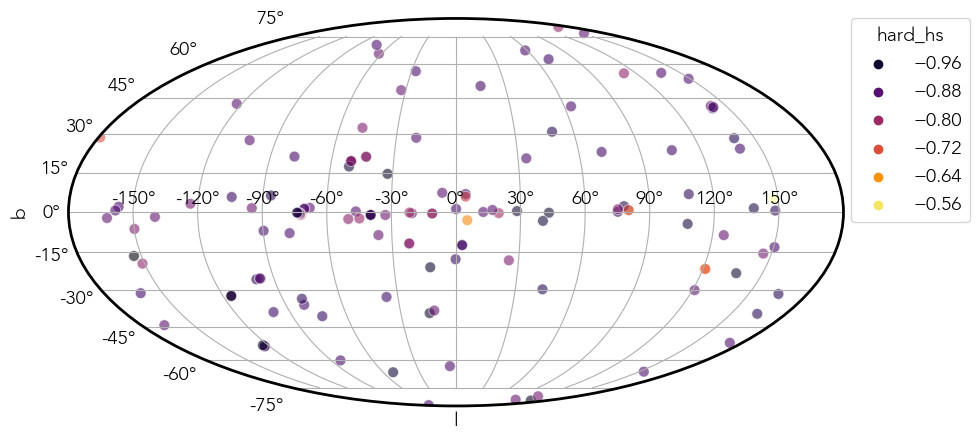

In [10]:
df_class_confident_with_coords_to_plot = df_class_confident_with_coords[(df_class_confident_with_coords['hard_hm'] <= -0.5) & (df_class_confident_with_coords['hard_hs'] <= -0.5)]
df_class_confident_with_coords_to_plot = df_class_confident_with_coords_to_plot[df_class_confident_with_coords_to_plot.agg_master_class == 'YSO']
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='mollweide')
ax.grid(True)

scatter = sns.scatterplot(data=df_class_confident_with_coords_to_plot, x='l', y='b', hue='hard_hs', palette="inferno", alpha=0.6, s=60, rasterized=True)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title='hard_hs')
ax.annotate('Fornax Cluster', xy=[4.13, 0.93])
#plt.savefig('./figures/results_hards_m0.5.pdf', bbox_inches='tight')  

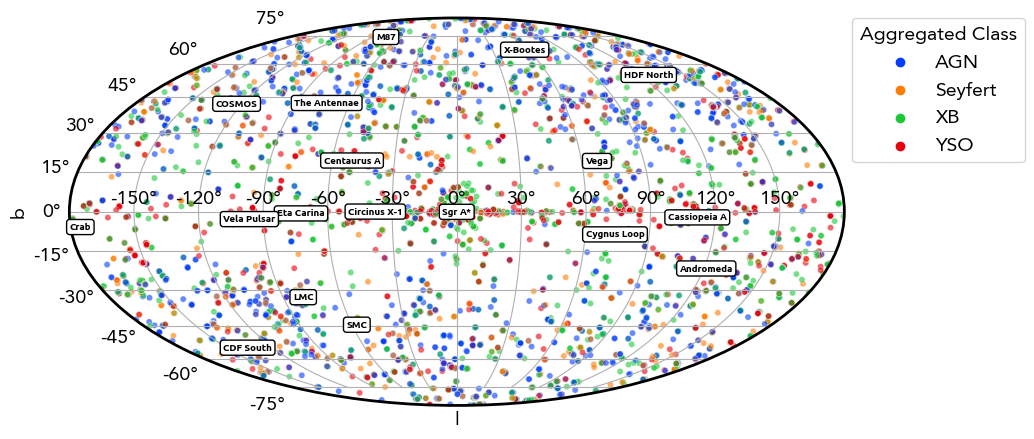

In [13]:
tags = {
    'Andromeda': {'ra': 10.68458, 'dec': 41.26917},
    'Circinus X-1': {'ra': 230.17021, 'dec': -57.17336},
#    'Cygnus OB2': {'ra': 308.17066, 'dec': 41.24147},
    'LMC': {'ra': 80.89417, 'dec': -69.75610},
    'SMC': {'ra': 13.18667, 'dec': -72.82861},
    'The Antennae': {'ra': 180.47083 , 'dec': -18.86944},
#    'Coma Cluster': {'ra': 194.95292, 'dec': 27.98056},
#    'E0102-12.2': {'ra':16.00625, 'dec': -72.03214},
#    'M31': {'ra': 10.68471, 'dec': 41.26875},
#    'SN 1987a': {'ra': 83.90846, 'dec': -69.26994},
    'Cassiopeia A': {'ra': 350.85830 , 'dec': 58.80000},
    'COSMOS': {'ra': 150.11917, 'dec': 2.20583},
#    'Eagle Nebula': {'ra': 274.70000, 'dec': -13.81670},
    'M87': {'ra': 187.70592, 'dec': 12.39112},
    'Vega': {'ra': 279.23473, 'dec': 38.78369},
    'CDF South': {'ra': 53.11667, 'dec': -27.80833},
    'Crab': {'ra': 83.63330, 'dec': 22.01440},
    'Eta Carina': {'ra': 161.25154, 'dec': -59.69778},
#    'M101': {'ra': 210.80227, 'dec': 54.34895},
    'Vela Pulsar': {'ra': 128.83454, 'dec': -45.17858},
    'Centaurus A': {'ra': 201.36500, 'dec': -43.01917},
    'Cygnus Loop': {'ra': 312.74225, 'dec': 30.65367},
    'HDF North': {'ra':189.23129, 'dec': 62.23721},
    'Sgr A*': {'ra': 266.41684, 'dec': -29.00781},
    'X-Bootes': {'ra': 218.02375, 'dec': 34.27986}
}

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='mollweide')
ax.grid(True)

scatter = sns.scatterplot(data=df_class_confident_with_coords, x='l', y='b', hue='agg_master_class', palette="bright", hue_order=grouped_types, alpha=0.6, s=20, rasterized=True)

# Plotting tags of regions of interest
for tag, coordinates in tags.items():
    eq = SkyCoord(ra=coordinates['ra'], dec=coordinates['dec'], unit=u.deg)
    gal = eq.galactic
    l_rad = gal.l.wrap_at('180d').radian
    b_rad = gal.b.radian
    ax.text(l_rad, b_rad, tag, fontsize=7, ha='center', va='center', color='black', weight='bold',  zorder=10, fontname='Ubuntu', 
             bbox=dict(boxstyle="round",
                   ec='black',
                   fc='white',
                   ))

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title='Aggregated Class')

plt.savefig('./figures/anno_results_galactic_classes.pdf', bbox_inches='tight')  

In [ ]:
fig, axs = plt.subplots(2, 2, subplot_kw=dict(projection='mollweide'), figsize=(20,10), tight_layout=True)

for i, ax in enumerate(fig.axes):
    ax.set_title(grouped_types[i], size=16)
    
    df_coords_cl = df_class_confident_with_coords[df_class_confident_with_coords.agg_master_class == grouped_types[i]]

    x=df_coords_cl.l
    y=df_coords_cl.b

    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    cf = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=1, shading='auto', cmap='inferno', edgecolors='none', rasterized=True)

plt.savefig('./figures/results_galactic_classes_dens.pdf', bbox_inches='tight')  

#### To LaTeX
---

In [ ]:
def bold_class_prob(row):
    to_format = row[row['master_class']]
    row[row.master_class] = "\\textbf{%s}" % to_format
    return row

In [ ]:
df_cc_to_latex = df_class_confident.apply(lambda x: bold_class_prob(x), axis=1)

In [ ]:
df_cc_to_latex.head(10).to_latex('latex_file.txt')

In [ ]:
df_class_confused.head(10).to_latex('latex_file.txt')

In [ ]:
data_cluster = pd.read_csv('./out_data/cluster_csc_simbad.csv')

In [ ]:
data_cluster.shape